In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler ,PowerTransformer ,Normalizer
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR


In [2]:
def cross_validation(model, X_TRAIN, y_TRAIN, verbose): 
    preds = cross_val_predict(model, X_TRAIN, y_TRAIN, cv=KFold(n_splits=4, shuffle=True, random_state=42))
            
    if verbose:
        model_test(y_TRAIN, preds)

    return explained_variance_score(y_TRAIN, preds)

In [3]:
def cross_validation2(model, X_TRAIN, y_TRAIN, verbose): 
    preds = cross_val_predict(model, X_TRAIN, y_TRAIN, cv=KFold(n_splits=4, shuffle=True, random_state=42))
            
    if verbose:
        model_test(y_TRAIN, preds)

    return mean_squared_error(y_TRAIN, preds)

In [4]:


def model_test(y_validation, preds):
    print("The RVE is:", explained_variance_score(y_validation, preds))
    print("The RMSE is:", mean_squared_error(y_validation, preds, squared=False))
    corr, pval = pearsonr(y_validation, preds)
    print(f"The Correlation Score is: {corr:.4f} (p-value={pval:e})")
    print("The Maximum Error is:", max_error(y_validation, preds))
    print("The Mean Absolute Error is:", mean_absolute_error(y_validation, preds))

X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=123)
X_test = pd.DataFrame(X_test, columns=col_names)
X_train = pd.DataFrame(X_train, columns=col_names)
X_ivs = pd.DataFrame(X_ivs, columns=col_names)



In [5]:
import pandas as pd

data = X_test

num_binary_columns = 0
nome_bin_col = []  

for column in data.columns:
    unique_values = data[column].unique()
    if len(unique_values) == 2 and set(unique_values) == {0, 1}:
        num_binary_columns += 1
        nome_bin_col.append(column)
print(len(nome_bin_col))

2090


In [6]:
X_ivs_bin = X_ivs[nome_bin_col]


non_bin_cols_ivs = [col for col in X_ivs.columns if col not in nome_bin_col]
X_ivs_non_bin = X_ivs[non_bin_cols_ivs]


X_test_bin = X_test[nome_bin_col]


non_bin_cols_test = [col for col in X_test.columns if col not in nome_bin_col]
X_test_non_bin = X_test[non_bin_cols_test]


X_train_bin = X_train[nome_bin_col]

non_bin_cols_train = [col for col in X_train.columns if col not in nome_bin_col]
X_train_non_bin = X_train[non_bin_cols_train]

X_test = X_test_non_bin

X_ivs = X_ivs_non_bin


In [7]:
scalers = {
    "MINMAX": MinMaxScaler(),
    "STANDART": StandardScaler(),
    "NORMALIZER": Normalizer(),
    "POWER": PowerTransformer()
}
rve_scalers = []

for scaler in scalers:
    print("--------------------------------", scaler)
    X_TRAIN_IMPUTED_SCALED = scalers[scaler].fit_transform(X_train_non_bin)

    rve_scalers.append(cross_validation2(DecisionTreeRegressor(random_state=123), X_TRAIN_IMPUTED_SCALED, y_train, 1))

best_rmse_scalers = max(rve_scalers)
index_best_rmse_scalers = rve_scalers.index(best_rmse_scalers)

if(index_best_rmse_scalers == 0):
    print("Melhor Scaler = MinMaxScaler")
    scaler = scalers["MINMAX"]
elif (index_best_rmse_scalers == 1):
    print("Melhor Scaler = StandartScaler")
    scaler = scalers["STANDART"]
elif (index_best_rmse_scalers == 2):
    print("Melhor Scaler = Normalizer")
    scaler = scalers["NORMALIZER"]
else:
    print("Melhor Scaler = PowerTransformer")
    scaler = scalers["POWER"]

X_train_imputed_scaled = scaler.fit_transform(X_train_non_bin)
X_test = scaler.fit_transform(X_test)
X_ivs = scaler.fit_transform(X_ivs)


-------------------------------- MINMAX
The RVE is: -0.10939429189170413
The RMSE is: 0.29041159451606785
The Correlation Score is: 0.4453 (p-value=5.746506e-284)
The Maximum Error is: 1.0
The Mean Absolute Error is: 0.20962827569928152
-------------------------------- STANDART
The RVE is: -0.10804154791950848
The RMSE is: 0.2902288783905562
The Correlation Score is: 0.4457 (p-value=1.908388e-284)
The Maximum Error is: 1.0
The Mean Absolute Error is: 0.20874665370621057
-------------------------------- NORMALIZER
The RVE is: -0.12216532038580152
The RMSE is: 0.2920712908923828
The Correlation Score is: 0.4433 (p-value=3.748919e-281)
The Maximum Error is: 1.0
The Mean Absolute Error is: 0.20974064939360762
-------------------------------- POWER


c:\Users\tomas\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


The RVE is: -0.10207003424769612
The RMSE is: 0.2894650259928945
The Correlation Score is: 0.4500 (p-value=1.142742e-290)
The Maximum Error is: 1.0
The Mean Absolute Error is: 0.2082954120050264
Melhor Scaler = Normalizer


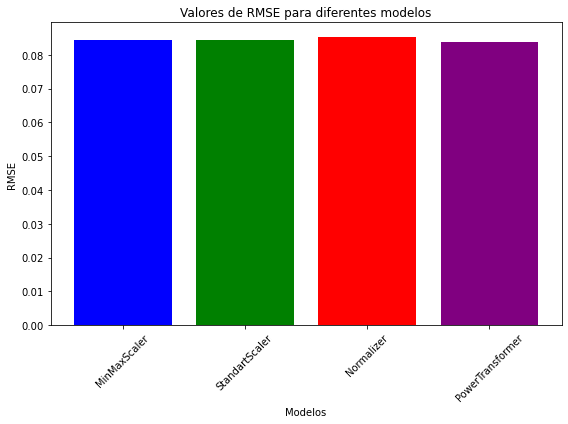

In [8]:
scalers_names = ['MinMaxScaler', 'StandartScaler', 'Normalizer', 'PowerTransformer'] 


plt.figure(figsize=(8, 6))
plt.bar(scalers_names, rve_scalers, color=['blue', 'green', 'red', 'purple'])

plt.title('Valores de RMSE para diferentes modelos')
plt.xlabel('Modelos')
plt.ylabel('RMSE')

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [9]:
X_train_final = pd.concat([pd.DataFrame(X_train_imputed_scaled), X_train_bin], axis=1)

X_test_final = pd.concat([pd.DataFrame(X_test), X_test_bin], axis=1)

X_ivs_final = pd.concat([pd.DataFrame(X_ivs), X_ivs_bin], axis=1)

In [10]:
X_TRAIN = X_train_final.copy()
X_validation = X_test_final.copy()
y_TRAIN = y_train.copy()
y_validation = y_test.copy()

X_TRAIN.columns = X_TRAIN.columns.astype(str)
X_validation.columns = X_validation.columns.astype(str)
cv=3

model = LinearSVR()
params = {   'C': [0.003,0.002,0.001,0.005,0.004],
            'epsilon': [0.05,0.04,0.03,0.06,0.0]
                }

grid = GridSearchCV(estimator=model, param_grid=params, scoring={'neg_mean_squared_error':'neg_mean_squared_error','neg_mean_absolute_error':'neg_mean_absolute_error'},
                        refit=False, cv=cv)

grid.fit(X_TRAIN, y_TRAIN)

average_scores = (grid.cv_results_['mean_test_neg_mean_squared_error'] +
                        grid.cv_results_['mean_test_neg_mean_absolute_error']) /2

best_params = grid.cv_results_['params'][average_scores.argmax()]
model = LinearSVR(**best_params)
model.fit(X_TRAIN, y_TRAIN)
preds_after_tuning = model.predict(X_validation)
print("Best hyperparameters:", best_params)

print("---------------AFTER TUNING----------------", "LinearSVR")
model_test(y_validation, preds_after_tuning)
print("\n")
print("\n")

Best hyperparameters: {'C': 0.003, 'epsilon': 0.05}
---------------AFTER TUNING---------------- LinearSVR
The RVE is: 0.6094105097275
The RMSE is: 0.17518528137551093
The Correlation Score is: 0.7807 (p-value=1.186491e-301)
The Maximum Error is: 0.730829390000769
The Mean Absolute Error is: 0.13539271674410652






In [11]:
X_TRAIN = X_train_final.copy()
X_validation = X_test_final.copy()
y_TRAIN = y_train.copy()
y_validation = y_test.copy()
X_ivs_validation = X_ivs_final.copy()


X_ivs_validation.columns = X_ivs_validation.columns.astype(str)
X_TRAIN.columns = X_TRAIN.columns.astype(str)
X_validation.columns = X_validation.columns.astype(str)
X_ivs_final = X_ivs_final.columns.astype(str)

model=RandomForestRegressor(n_jobs=-1,n_estimators=500)

model_name = "RANDOM FOREST REGRESSOR"
cv=2

print("---------------BEFORE TUNING----------------", model_name)
model.fit(X_TRAIN, y_TRAIN)
preds_before_tuning = model.predict(X_validation)
model_test(y_validation, preds_before_tuning)

print("\n")
print("\n")






---------------BEFORE TUNING---------------- RANDOM FOREST REGRESSOR
The RVE is: 0.6528089509844452
The RMSE is: 0.16550868029523183
The Correlation Score is: 0.8105 (p-value=0.000000e+00)
The Maximum Error is: 0.8109153169563666
The Mean Absolute Error is: 0.12748962202929043






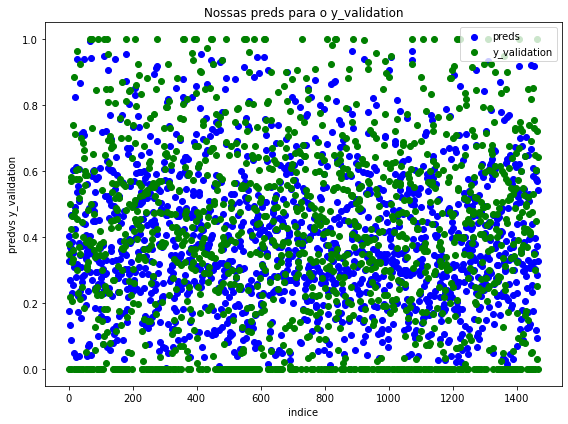

In [12]:
plt.figure(figsize=(8, 6))

plt.scatter(range(len(preds_before_tuning)), preds_before_tuning, color='blue', label='preds')
plt.scatter(range(len(y_validation)), y_validation, color='green', label='y_validation')

plt.title('Nossas preds para o y_validation')
plt.xlabel('indice')
plt.ylabel('predvs y_validation')

plt.legend()
plt.tight_layout()
plt.show()

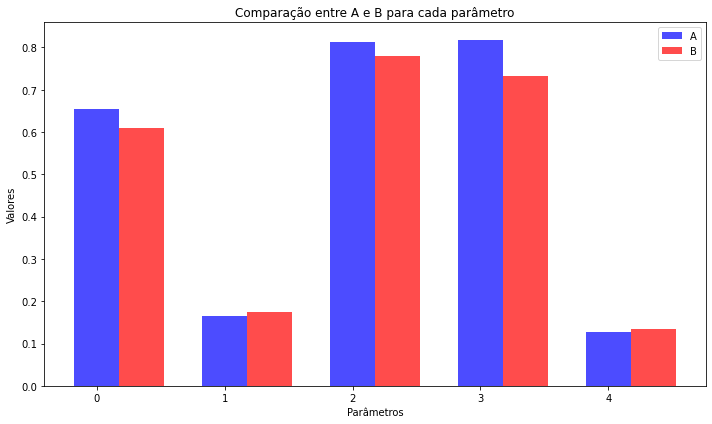

In [13]:

scalers_names = ['RVE','RMSE','Correlation Score','Maximum Error', 'Mean Absolute Error']
a = [0.6547404776435308, 0.16504630242619828, 0.8120, 0.8182667202063334, 0.12729703666437478]
b = [0.6094332086150093, 0.17517247010962203, 0.7807, 0.7313816884743, 0.13537904518992538]


plt.figure(figsize=(10, 6))

bar_width = 0.35
index = range(len(scalers_names))

plt.bar(index, a, 0.35, label='A', color='b', alpha=0.7)
plt.bar([i + 0.35 for i in index], b, 0.35, label='B', color='r', alpha=0.7)

plt.xlabel('Parâmetros')
plt.ylabel('Valores')
plt.title('Comparação entre A e B para cada parâmetro')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
preds_to_file = model.predict(X_ivs_validation)

In [15]:
np.savetxt('32.txt', preds_to_file, fmt='%.3f')